In [1]:
#x01_populationStatistics

In [2]:
from chewc.callback import *
from chewc.policy import *
from chewc.sim import *
from chewc.lab import *
from chewc.config import *

In [3]:
import matplotlib.pyplot as plt
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np
device='cpu'
from torch.utils.tensorboard import SummaryWriter



import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList


In [4]:
#| export

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from chewc.sim import *
import torch

class SelectionIntensityEnvironment(gym.Env):
    def __init__(self, SP, config):
        super(SelectionIntensityEnvironment, self).__init__()
        self.SP = SP
        self.config = config  # Store the config
        self.current_generation = 0
        self.max_generations = SP.max_generations
        # Get action space bounds from config, with defaults if not provided
        
        self.action_low = config.get('action_low', 0.05)
        self.action_high = config.get('action_high', 0.95)
        
        self.action_space = gym.spaces.Box(
            low=np.array([self.action_low]), 
            high=np.array([self.action_high]), 
            dtype=np.float32
        )
        
        # Update observation space based on config
#         obs_config = config['observation_config']['remaining_proportion']
        self.observation_config = config['observation_config']
        # Dynamically create observation space
        obs_low = []
        obs_high = []
        self.obs_keys = []
        for key, value in self.observation_config.items():
            self.obs_keys.append(key)
            obs_low.append(value['low'])
            obs_high.append(value['high'])
        
        self.observation_space = gym.spaces.Box(
            low=np.array(obs_low, dtype=np.float32),
            high=np.array(obs_high, dtype=np.float32)
        )

        self.action_values = []
        self.genetic_variance = []
        self.max_breeding_values = []
        self.final_generations = []
        self.episode_count = 0
        self.rewards = []
        self.episode_reward = 0
        
        #config
        self.config =config
        
    def _get_obs(self):
        obs = []
        for key in self.obs_keys:
            if key == 'remaining_proportion':
                obs.append(1 - (self.current_generation / self.max_generations))
            elif key == 'genetic_variance':
                obs.append(self.population.breeding_values.var().cpu().item())
            elif key == 'mean_phenotype':
                obs.append(self.population.phenotypes.mean().cpu().item())
            elif key == 'max_breeding_value':
                obs.append(self.population.breeding_values.max().cpu().item())
            # Add more elif statements for other possible inputs
        return np.array(obs, dtype=np.float32)


    def _get_info(self):
        return {
            "max_phenotype": self.population.breeding_values.max().cpu().item(),
            "genetic_variance": self.population.breeding_values.var().cpu().item(),
            "current_generation": self.current_generation
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.population = self.SP.founder_pop
        self.phenotype = phenotype(self.population, self.SP.T, self.SP.h2)
        self.current_generation = 0
        self.episode_reward = 0
        observation = self._get_obs()
        info = self._get_info()
        
        return observation, info

    def step(self, action):
        
        # Map the action from [-1, 1] to [action_low, action_high]
        action = scale_values(action, to_range=(self.action_low, self.action_high))

        total_selected = max((2,int(action * self.population.size)))
        selected = torch.topk(self.population.phenotypes, total_selected).indices
        self.population = create_pop(self.SP.G, random_crosses(self.population.haplotypes[selected], self.SP.pop_size))
        self.phenotype = phenotype(self.population, self.SP.T, self.SP.h2)
        self.current_generation += 1

        observation = self._get_obs()
        info = self._get_info()
        info['normalized_action'] = action
        
        terminated = self.current_generation > self.SP.max_generations
        #REWARD
        if self.config.get('sparse_reward', False):  # Use .get() with a default value
            reward = 0 if not terminated else float(self.population.breeding_values.max())
        else:
            reward = float(self.population.breeding_values.max())
        self.episode_reward += reward

        if terminated:
            info['final_generation'] = {
            "max_phenotype": self.population.breeding_values.max().cpu().item(),
            "genetic_variance": self.population.breeding_values.var().cpu().item(),
            "current_generation": self.current_generation
            }

        return observation, reward, bool(terminated), False, info

import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy

class CustomFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(CustomFeatureExtractor, self).__init__(observation_space, features_dim)
        
        # For now, a simple linear layer for the scalar input
        self.linear = nn.Sequential(
            nn.Linear(observation_space.shape[0], features_dim),
            nn.ReLU()
        )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(observations)

class CustomPolicy(ActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(
            *args,
            **kwargs,
            features_extractor_class=CustomFeatureExtractor,
            features_extractor_kwargs=dict(features_dim=64)
        )

In [5]:
env = create_simulation()
env.reset()

(array([1.], dtype=float32),
 {'max_phenotype': 1.6615780591964722,
  'genetic_variance': 0.9999998211860657,
  'current_generation': 0})

In [6]:
FE = CustomFeatureExtractor(env.observation_space)
mock_observation = th.tensor([[0.5]], dtype=th.float32)  # Single scalar input
FE(mock_observation)

tensor([[0.3485, 0.0000, 0.0000, 0.0000, 0.8752, 0.2201, 0.0000, 0.0000, 0.0000,
         1.0470, 1.0424, 0.3086, 0.1597, 0.0000, 0.3679, 0.0000, 0.0000, 0.0000,
         1.1438, 0.0000, 0.0000, 0.5739, 0.3388, 0.6796, 0.0000, 0.6212, 0.5961,
         0.6320, 0.0000, 0.0000, 0.0000, 0.0000, 0.5648, 0.6760, 0.6271, 0.3069,
         0.1339, 0.0000, 0.0000, 0.3297, 0.4514, 0.1258, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.7184, 0.8602, 0.1806, 0.2160, 0.0000,
         0.1519, 0.0000, 0.3281, 0.0000, 0.0000, 0.1922, 0.0000, 0.0000, 0.9675,
         0.5229]], grad_fn=<ReluBackward0>)

In [7]:
model = PPO(CustomPolicy, env, verbose=1)

model.learn(total_timesteps=100)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11       |
|    ep_rew_mean     | 29.7     |
| time/              |          |
|    fps             | 746      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


In [8]:

def create_simulation(config=None):
    if config is None:
        config = get_default_config()
    
    seed = config['seed']
    set_seed(seed)
    
    G = Genome(config['n_chr'], config['n_loci'], seed=seed)
    
    founder_haplotypes = np.load('../nbs/data/g2f_ch10.npy')
    random_parent_indices = np.random.choice(founder_haplotypes.shape[0], config['n_parents'], replace=False)
    random_loci_indices = np.random.choice(founder_haplotypes.shape[2], config['n_loci'], replace=False)
    
    founder_haplotypes = founder_haplotypes[random_parent_indices,:,:]
    founder_haplotypes = founder_haplotypes[:,:,random_loci_indices]
    founder_haplotypes = torch.tensor(founder_haplotypes).unsqueeze(2)
    
    inbred_founders = create_pop(G, founder_haplotypes)
    f1 = create_pop(G, random_crosses(inbred_founders.haplotypes, 1000))
    founder_pop = create_pop(G, random_crosses(f1.haplotypes, config['pop_size']))
    
    T = Trait(G, founder_pop, target_mean=config['target_mean'], target_variance=config['target_variance'], seed=seed)
    
    SP = SimParams(founder_pop, config)
    env = SelectionIntensityEnvironment(SP, config)
    
    return env




In [9]:
config = get_default_config()
config['n_parents'] = 2
config['n_loci'] = 50
config['pop_size'] = 100
config['max_generations'] = 10
config['total_timesteps'] = 5000000
config['seed'] = 8
for i in config:
    print(f"{i} : {config[i]}")
env = create_simulation(config)
env.reset()


observation_config : {'remaining_proportion': {'type': 'scalar', 'low': 0, 'high': 1}, 'genetic_variance': {'type': 'scalar', 'low': 0, 'high': inf}, 'mean_phenotype': {'type': 'scalar', 'low': -inf, 'high': inf}, 'max_breeding_value': {'type': 'scalar', 'low': -inf, 'high': inf}}
action_low : 0.05
action_high : 0.95
sparse_reward : False
n_parents : 2
n_chr : 1
n_loci : 50
pop_size : 100
max_generations : 10
h2 : 0.5
target_mean : 0
target_variance : 1
reps : 1
total_timesteps : 5000000
learning_rate : 0.0003
gae_lambda : 0.95
log_freq : 100
start_gen : 10
end_gen : 100
start_gae_lambda : 0.9
end_gae_lambda : 0.95
seed : 8


(array([1.        , 0.99999976, 4.3533897 , 6.8917513 ], dtype=float32),
 {'max_phenotype': 6.891751289367676,
  'genetic_variance': 0.9999997615814209,
  'current_generation': 0})

Best action: -0.444
Best average max phenotype in final generation: 13.246


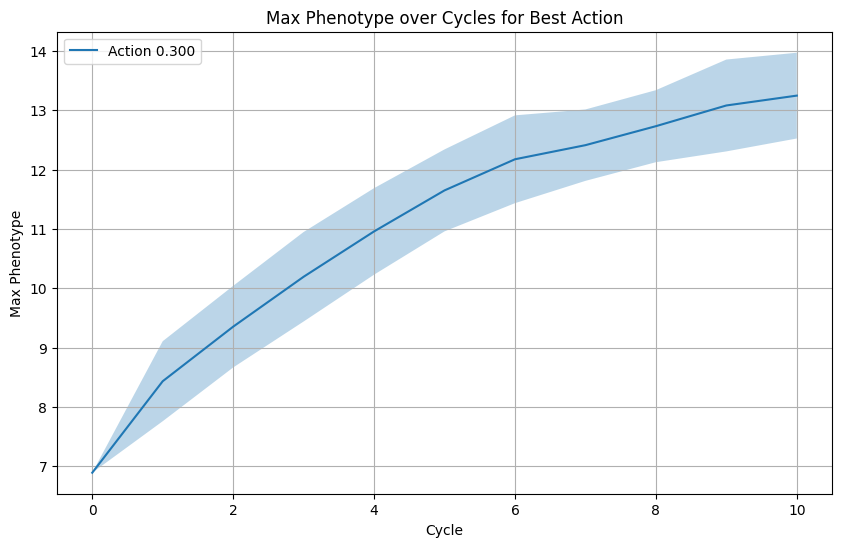

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def collect_baselines(env, actions, repetitions=10, cycles=5):
    results = {action: {'max_phenotype': [], 'gv': []} for action in actions}
    final_gen_averages = {}
    env.reset()
    for action in actions:
        final_gen_phenotypes = []
        for _ in range(repetitions):
            env.reset()
            cycle_max_phenotype = []
            cycle_gv = []
            cycle_max_phenotype.append(env.population.breeding_values.max())
            cycle_gv.append(env.population.breeding_values.var())
            for _ in range(cycles):
                env.step(np.array([action]))
                max_phenotype = env.population.breeding_values.max()
                gv = env.population.breeding_values.var()
                cycle_max_phenotype.append(max_phenotype)
                cycle_gv.append(gv)
            
            results[action]['max_phenotype'].append(cycle_max_phenotype)
            results[action]['gv'].append(cycle_gv)
            final_gen_phenotypes.append(cycle_max_phenotype[-1])
        
        final_gen_averages[action] = np.mean(final_gen_phenotypes)
    
    best_action = max(final_gen_averages, key=final_gen_averages.get)
    best_average = final_gen_averages[best_action]
    
    return results, best_action, best_average

def plot_best_run(results, best_action):
    plt.figure(figsize=(10, 6))
    
    max_phenotypes = np.array(results[best_action]['max_phenotype'])
    mean_values = np.mean(max_phenotypes, axis=0)
    std_values = np.std(max_phenotypes, axis=0)
    cycles = range(len(mean_values))
    best_action_translated = scale_values(best_action)
    
    plt.plot(cycles, mean_values, label=f'Action {best_action_translated:.3f}')
    plt.fill_between(cycles, mean_values - std_values, mean_values + std_values, alpha=0.3)
    
    plt.xlabel('Cycle')
    plt.ylabel('Max Phenotype')
    plt.title(f'Max Phenotype over Cycles for Best Action')
    plt.legend()
    plt.grid(True)
    plt.show()



# Usage
actions = np.linspace(-1, 0, 10)  # or however many actions you want to test
results, best_action, best_average = collect_baselines(env, actions, repetitions=10, cycles=env.SP.max_generations)

print(f"Best action: {best_action:.3f}")
print(f"Best average max phenotype in final generation: {best_average:.3f}")

# Plot only the best run
plot_best_run(results, best_action)


In [11]:

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    tensorboard_log='../dev_nbs/ppotb'
)


# model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=1000)
action_callback = ActionTrackingCallback(log_freq=1000)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../dev_nbs/ppotb/PPO_39


/home/glect/miniconda3/envs/breeding/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_generations to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_generations` for environment variables or `env.get_wrapper_attr('max_generations')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11       |
|    ep_rew_mean     | 112      |
| time/              |          |
|    fps             | 865      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11           |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 778          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0042181844 |
|    clip_fraction        | 0.0378       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.00109      |
|    learning_r

KeyboardInterrupt: 

In [ ]:
plt.hist(env.population.breeding_values)

In [ ]:
env.SP.max_generations

In [ ]:

# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=1000)
action_callback = ActionTrackingCallback(log_freq=1000)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
vec_env = DummyVecEnv([lambda: env])
# Create and train the model with the custom policy
model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

In [ ]:
config['sparse_reward'] =True
env = create_simulation(config)
env.reset()
# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=1000)
action_callback = ActionTrackingCallback(log_freq=1000)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
vec_env = DummyVecEnv([lambda: env])
# Create and train the model with the custom policy
model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)